The team for this project is:
- Marc-César Garcia-Grenet
- Thomas Bodart
- Macéo Duriez

This notebook contains all the work done for the task 1, by Thomas Bodart.

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from collections import Counter
import highway_env
import torch
import torch.nn as nn
from copy import deepcopy
from collections import deque
import random

Some utilities

In [24]:
%matplotlib inline
def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, use_epsilon=False)
        state, reward, terminated, truncated, _ = display_env.step(action)
        done = terminated or truncated
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'total episode reward {rewards}')

def eval_agent(agent, env, n_sim=10):
    """    
    Monte Carlo evaluation of the agent.

    Repeat n_sim times:
        * Run the agent policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, use_epsilon=False)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

class RandomAgent: 
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        return
    
    def get_action(self, state, **kwargs):
        return self.action_space.sample()
    
    def update(self):
        pass

Some utilities functions: train, curves

In [17]:
def train(env, agent, N_episodes, eval_every=100, reward_threshold=300, n_eval=10, save_model=False):
    total_time = 0
    all_rewards = []
    all_lengths = []
    eval_rewards = []
    
    for ep in tqdm(range(N_episodes), desc="Training..."):
        done = False
        state, _ = env.reset()
        ep_reward = 0
        steps = 0

        while not done: 
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # agent.store_transition(state, action, actual_reward, next_state, terminated)
            agent.store_transition(state, action, reward, next_state, terminated)
            agent.update()

            state = next_state
            done = terminated or truncated

            ep_reward += reward
            steps += 1
            total_time += 1

        all_rewards.append(ep_reward)
        all_lengths.append(steps)

        if (ep + 1) % eval_every == 0:
            mean_eval_reward = np.mean(eval_agent(agent, env, n_sim=n_eval))
            eval_rewards.append((ep + 1, mean_eval_reward))
            print(f"[Episode {ep+1}] Eval reward: {mean_eval_reward:.2f} | Train reward: {ep_reward:.2f} | Steps: {steps}")
            
            if save_model:
                torch.save(agent.policy_net.state_dict(), f"model_ep{ep+1}.pt")

            if mean_eval_reward >= reward_threshold:
                print("Reward threshold reached! Stopping early.")
                break

    print("\n Training complete.")
    _plot_training_curves(all_rewards, eval_rewards, agent.learning_rate)
    return all_rewards, eval_rewards, all_lengths


def _plot_training_curves(all_rewards, eval_rewards, learning_rate):
    plt.figure(figsize=(12, 5))

    # Smoothed training reward
    smoothed_rewards = np.convolve(all_rewards, np.ones(10) / 10, mode='valid')
    plt.plot(smoothed_rewards, label='Train Reward (smoothed)', alpha=0.7)

    if eval_rewards:
        eval_eps, eval_vals = zip(*eval_rewards)
        plt.plot(eval_eps, eval_vals, 'o-', label='Eval Reward', color='red')

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Training and Evaluation Reward Over Time, with lr: {learning_rate}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Task 1: Pre-specified environment
Let us first define the environment

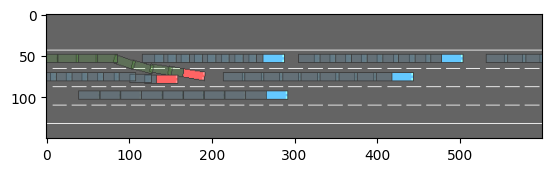

total episode reward 4.639460713116491


In [18]:

config_dict = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 10,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20],
        },
        "grid_size": [[-20, 20], [-20, 20]],
        "grid_step": [5, 5],
        "absolute": False,
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "lanes_count": 4,
    "vehicles_count": 15,
    "duration": 60,  # [s]
    "initial_spacing": 0,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.5,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 0.1,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,
    "reward_speed_range": [
        20,
        30,
    ],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD].
    "simulation_frequency": 5,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": True,
}

env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()


run_one_episode(env, RandomAgent(env.observation_space, env.action_space))

## General comments on the environment
### Observation space:
The observation space is a 8x8 grid, with the following channels (as in image):
- Presence: 1 if a car is here, 0 otherwise
- x and y: relative position
- vx, vy: relative velocities
- cos_h, sin_h: angle

### Action space:
There is 5 possible actions:
- IDLE: do nothing
- LEFT: go left
- RIGHT: go right
- FASTER: go faster
- SLOWER: go slower


In [19]:
print("Observation space shape: ", env.observation_space.shape)
print("Action space shape", env.action_space)


Observation space shape:  (7, 8, 8)
Action space shape Discrete(5)


## DQN Implementation
### Neural Network
Let us define the neural network for DQN. Since the observation space looks like an 8x8 image (with 7 channels), we will use CNN

In [20]:
class CNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=7, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.ln1 = nn.LayerNorm([16, 8, 8])
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.ln2 = nn.LayerNorm([32, 8, 8])
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 5)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
    
    def forward(self, observation_space: torch.FloatTensor):
        x = self.relu(self.ln1(self.conv1(observation_space)))
        x = self.relu(self.ln2(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
ex = torch.tensor([env.observation_space.sample()])
model = CNN()
model(ex)

tensor([[-0.0631,  0.1196, -0.0447, -0.0341, -0.0467]],
       grad_fn=<AddmmBackward0>)

### Agent
Let us now define the agent. 

In [21]:
class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


class DQNAgent:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        batch_size,
        learning_rate,
        weight_decay,
        model,
        optimizer,
        buffer_capacity
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

        self.policy_net = model.to(self.device)
        self.target_net = deepcopy(model).to(self.device)
        self.target_net.eval()

        self.learning_rate = learning_rate
        self.optimizer = optimizer(self.policy_net.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)

        self.steps = 0
        self.update_target_every = 100

        self.action_counter = Counter()
        self.epsilon = 0.1

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        transitions = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)

        states = torch.tensor(states, device=self.device, dtype=torch.float32)
        actions = torch.tensor(actions, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, device=self.device, dtype=torch.float32)
        dones = torch.tensor(dones, device=self.device, dtype=torch.float32).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = torch.nn.functional.smooth_l1_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def get_action(self, state, use_epsilon=True):
        if use_epsilon and random.random() < self.epsilon:
            action = self.action_space.sample()
            self.action_counter[action] += 1
            return action 

        state_tensor = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        
        action = q_values.argmax().item()
        self.action_counter[action] += 1
        return action
        
    def reset_action_counter(self):
        self.action_counter = Counter()


mean reward before training =  4.58588736604012


Training...:  10%|█         | 50/500 [00:44<23:47,  3.17s/it]

[Episode 50] Eval reward: 48.42 | Train reward: 52.92 | Steps: 60


Training...:  20%|██        | 100/500 [01:43<14:52,  2.23s/it]

[Episode 100] Eval reward: 28.58 | Train reward: 3.14 | Steps: 4


Training...:  30%|███       | 150/500 [02:43<17:39,  3.03s/it]

[Episode 150] Eval reward: 49.95 | Train reward: 10.25 | Steps: 14


Training...:  40%|████      | 200/500 [03:49<14:30,  2.90s/it]

[Episode 200] Eval reward: 45.20 | Train reward: 55.84 | Steps: 60


Training...:  50%|█████     | 250/500 [04:43<13:38,  3.27s/it]

[Episode 250] Eval reward: 46.90 | Train reward: 54.18 | Steps: 60


Training...:  60%|██████    | 301/500 [05:37<05:10,  1.56s/it]

[Episode 300] Eval reward: 47.47 | Train reward: 16.68 | Steps: 19


Training...:  70%|███████   | 350/500 [06:37<07:46,  3.11s/it]

[Episode 350] Eval reward: 52.07 | Train reward: 10.80 | Steps: 16


Training...:  80%|████████  | 401/500 [07:48<04:10,  2.53s/it]

[Episode 400] Eval reward: 50.74 | Train reward: 50.92 | Steps: 60


Training...:  90%|█████████ | 451/500 [08:53<01:32,  1.88s/it]

[Episode 450] Eval reward: 50.86 | Train reward: 2.73 | Steps: 4


Training...: 100%|██████████| 500/500 [10:01<00:00,  1.20s/it]

[Episode 500] Eval reward: 50.55 | Train reward: 54.48 | Steps: 60

 Training complete.


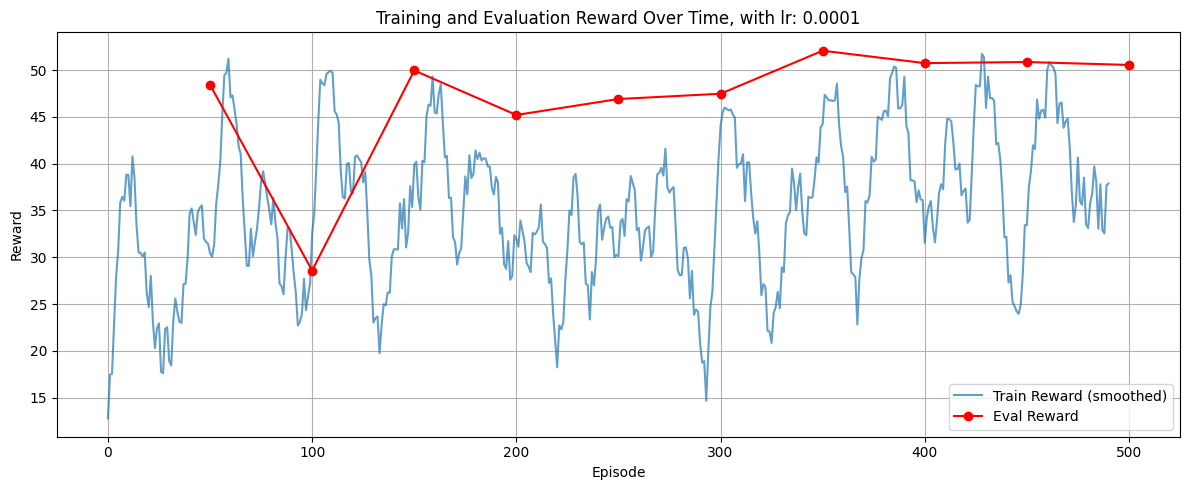

mean reward after training =  50.54606539583163


In [ ]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()

action_space = env.action_space
observation_space = env.observation_space

gamma = .99
episode_batch_size = 64
learning_rate = 1e-3
weight_decay = 0
model=CNN()
optimizer = torch.optim.Adam
N_episodes = 500

agent = DQNAgent(
    action_space=action_space,
    observation_space=observation_space,
    gamma=gamma,
    batch_size=episode_batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    model=model,
    optimizer=optimizer,
    buffer_capacity=1000,
)

print("mean reward before training = ", np.mean(eval_agent(agent, env, 10)))
# Run the training loop
train(env, agent, N_episodes, eval_every=50,)

# Evaluate the final policy
print("mean reward after training = ", np.mean(eval_agent(agent, env, 10)))


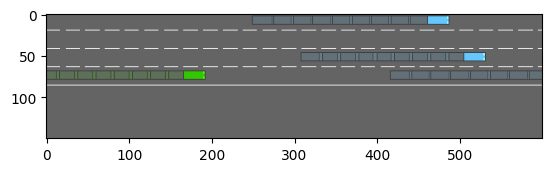

total episode reward 56.03553060691546
Counter({2: 54, 1: 5, 4: 1})


In [29]:
env.reset()

agent.reset_action_counter()

run_one_episode(env, agent)

print(agent.action_counter)